<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item">
    
<li><span><a href="#1.-Introduction" data-toc-modified-id=" Introduction"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li>
    
<li><span><a href="#2.-Environment-of-the-project" data-toc-modified-id="2.Environment of the project"><span class="toc-item-num">2&nbsp;&nbsp;</span>Environment of the project</a></span></li>
    
<li><span><a href="#3.-Method-overview" data-toc-modified-id="3.-Method-overview"><span class="toc-item-num">3&nbsp;&nbsp;</span>Method overview</a></span></li>

<li><span><a href="#4.-Computer-vision" data-toc-modified-id="4.-Computer-vision"><span class="toc-item-num">4&nbsp;&nbsp;</span>Computer vision</a></span>
    <ul class="toc-item"><li><span><a href="#4.1.-Pre-processing-the-raw-image:" data-toc-modified-id="4.1.-Pre-processing-the-raw-image:"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Pre-processing the raw image:</a></span></li>
    <li><span><a href="#4.2.-Identification-of-Robot-State:" data-toc-modified-id="4.2.-Identification-of-Robot-State:"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Identification of Robot State:</a></span></li>
    <li><span><a href="#4.3.-Grid-Analysis:" data-toc-modified-id="4.3.-Grid-Analysis:"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Grid Analysis:</a></span></li></ul></li>
    
<li><span><a href="#5.-Path-finding" data-toc-modified-id="#5.-Path-finding"><span class="toc-item-num">5&nbsp;&nbsp;</span>Path finding</a></span></li>
    
<li><span><a href="#6.-Local-Navigation" data-toc-modified-id="#6.-Local-Navigation"><span class="toc-item-num">6&nbsp;&nbsp;</span>Local Navigation</a></span></li>
    
<li><span><a href="#7.-Filtering" data-toc-modified-id="#7.-Filtering"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filtering</a></span></li>
    
<li><span><a href="#8.-Controller" data-toc-modified-id="#8.-Controller"><span class="toc-item-num">8&nbsp;&nbsp;</span>Controller</a></span></li>
    
 <li><span><a href="#9.-Project-run" data-toc-modified-id="#9.-Project-run"><span class="toc-item-num">9&nbsp;&nbsp;</span>Project run</a></span></li>

<li><span><a href="#10.-Conclusion" data-toc-modified-id="#10.-Conclusion"><span class="toc-item-num">10&nbsp;&nbsp;</span>Conclusion</a></span></li>

In [1]:
from IPython.display import Image, display

# Vision guided navigation with Thymio - Final project
Authors: Ahmed Boubakry, Charles de Fournas, Julie Favre, Paul Richard

## 1. Introduction

The objective of this project is to develop a comprehensive robotic system for the Thymio robot, enabling it to navigate efficiently on a two-dimensional plane. The primary focus involves implementing advanced algorithms and methods to achieve global and local navigation, obstacle avoidance, accurate position estimation, and trajectory correction. The key components of our project include:

- Computer Vision in order to create the map and retrieve the robot's position: Utilizing computer vision techniques, we aim to create a map of the environment and accurately determine the Thymio robot's position in real-time<br><br>


- A* algorithm to find the optimal path:,Implementing the A* algorithm to find the optimal path from the starting position to the specified goal, considering the map and any obstacles encountered<br><br>

- Local navigation to avoid physical objects: Developing local navigation methods to enable the Thymio robot to dynamically adjust its path in real-time, effectively avoiding physical obstacles encountered during its movement<br><br>


- Filtering with Extended Kalman Filter to estimate accuretly the position: Employing the Extended Kalman Filter for precise and accurate estimation of the robot's position, enhancing the overall reliability of the navigation system and still providing the position of the robot if we don't see the camera<br><br>

- Controller to correct the trajectory after every move: The robot will change his direction in accord with the camera and theorical position.

## 2. Environment of the project

We have opted for a black and white grid as our environment, where white cells signify walkable areas and black cells represent walls. The robot's objective is to determine the optimal path from its starting position to a designated goal cell, indicated in blue.

For visualization purposes, we print the grid on an A0 page with 8 columns and 6 rows. The page's borders serve as reference points for the camera to deduce the grid. We've outlined the grid using black tape, aiding in its detection.

Obstacles are depicted by black cartoon representations, and the goal is visually distinguished by a blue cartoon. Additionally, on the robot, we've strategically positioned two black points – a smaller one in front of a larger one – to help the camera ascertain the robot's orientation.

The camera is mounted on a tripod with an extension, positioning it vertically above the center of our environment.

To enhance the camera's visibility, we've strategically placed multiple lamps to illuminate the area. These lamps are intended to provide ample lighting for improved camera performance.

In consideration of the Thymio sensor, obstacles are designed to be solid, ensuring effective detection by the sensor. It's important to note that these obstacles are shaped differently from rounds, as our camera primarily detects round forms for our robot.

<div style="text-align:center">
    <img src="image/env_2.jpg" alt="environnement" width="400"/>
</div>

## 3. Method overview

The program begins with the initialization of global variables and the importation of modules. Initially, we extract the grid and the robot position. The subsequent significant part of our code focuses on finding the optimal path to reach the destination.

Once the setup is complete, the main loop initiates. The robot moves from one position to another, and at regular intervals, the program analyzes and corrects its position. During each iteration, the loop checks for potential obstacles. If an obstacle is detected, a corresponding function is triggered to navigate around it. Otherwise, the program proceeds as usual, initiating a new loop to progress to the next step.

This loop continues until the final destination is reached. The structure ensures that the robot dynamically adapts its path, corrects its trajectory, and navigates around obstacles, providing a robust and efficient navigation system.

<img src="image/logic_map.jpg" alt="Method overview" width="800"/>

In [1]:
import cv2
import time

import numpy as np
import math
import copy
import asyncio

%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline

from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook

from tqdm import tqdm

from ExtendedKalmanFilter import EKF
import IPython.display as Disp
from ipywidgets import widgets

from tdmclient import ClientAsync, aw
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()


Node a13184be-b7ac-45c1-84e9-c4292b7f7ff2

#### Global Initialization


In [ ]:
#--------------- global initialization -----------------
x_end = y_end=0

class RobotState:
    def __init__(self, x=0, y=0, r=0, angle=0):
        self.x = x
        self.y = y
        self.angle = angle 

robot_state = RobotState()


# size of our environment grid
num_cases_x = 8  # horizontal cells (valeur arbitraire ici juste pour que ca marche dans mon exemple) 
num_cases_y = 6   # vertical cells

# Initializing our matrix containing the environment information
center_matrix = [[None for _ in range(num_cases_x)] for _ in range(num_cases_y)]
state_matrix = [[None for _ in range(num_cases_x)] for _ in range(num_cases_y)]
debug_matrix = [[None for _ in range(num_cases_x)] for _ in range(num_cases_y)]

#-----------------------------------------------------

#--------------- CV initialization -------------------

#camera related initialization 
cam = cv2.VideoCapture(0)

#Lower the resolution
cam.set(3, 1280)
cam.set(4, 720)

#-----------------------------------------------------

#--------------- Kalman initialization ---------------
ekf = None
last_time = time.monotonic()
#-----------------------------------------------------

#------------- Global Nav initialization -------------
count = 0
obstacle_state = 1
was_kidnapped = False
new_angle = 0
#-----------------------------------------------------


#### Utils


In [2]:
def calculate_angle_degrees(x1, y1, x2, y2):
    """
    Calculate the angle in degrees between two points (x1, y1) and (x2, y2).
    """
    delta_x = x2 - x1
    delta_y = y2 - y1
    angle_rad = math.atan2(delta_y, delta_x)
    
    # Convert angle to degrees
    angle_degrees = math.degrees(angle_rad)

    return angle_degrees

def calculate_distance(x1, y1, x2, y2):
    """
    Calculate the Euclidean distance between two points (x1, y1) and (x2, y2).
    """
    distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return distance

def truncate_coordinate(center_matrix, X, Y):
    '''
    Converts pixel coordinates into map coordinates. 
    It searches through a matrix to find the closest point to the given X, Y coordinates, 
    considering a certain threshold. Returns the corresponding map coordinates.

    :param center_matrix: The matrix representing the map.
    :param X: The X coordinate in pixels.
    :param Y: The Y coordinate in pixels.
    :return: The corresponding (x, y) coordinates on the map.
    '''
    threshold_x = 60
    threshold_y = 60
    num_cases_y, num_cases_x = center_matrix.shape[:2]  # Get the dimensions of the matrix

    for i in range(num_cases_y):
        for j in range(num_cases_x):
            diff_x = abs(center_matrix[i, j][0] - X)
            diff_y = abs(center_matrix[i, j][1] - Y)

            if diff_x <= threshold_x and diff_y <= threshold_y:
                x_out, y_out = j, i  
    return(x_out, y_out)

def symetrie_lignes(matrix):
    '''
    Performs a line symmetry transformation on the given matrix.
    This function inverts the rows of the matrix, swapping the first row with the last,
    the second row with the second to last, and so on.

    :param matrix: The matrix to be transformed.
    :return: The transformed matrix with inverted rows.
    '''
    copy_matrix = copy.deepcopy(matrix)
    matrix[0][:] = copy_matrix[5][:]
    matrix[1][:] = copy_matrix[4][:]
    matrix[2][:] = copy_matrix[3][:]
    matrix[3][:] = copy_matrix[2][:]
    matrix[4][:] = copy_matrix[1][:]
    matrix[5][:] = copy_matrix[0][:]
    return matrix
    
def get_speed(right, left):
    """Retrieves the speed of the robot. Constant coefficient to converse speed of motors to units we want
    returns: np.array- [linear_speed, angular speed] in pixels/sec and angle/sec
    """
    coeff_lin = 176/7
    coeff_angular = 37/200
    linear = ((right + left)/2) * coeff_lin
    angular = (right - left) * coeff_angular
    return np.array([linear, angular])

def normalize_angle(angle):
    """Normalize an angle to the range [-180, 180] degrees."""
    angle = angle % 360  # Normalize between 0 and 360
    if angle > 180:
        angle -= 360  # Adjust to the range [-180, 180]
    return angle
    

## 4. Computer vision


The integration of computer vision is crutial in our project for initializing and periodically updating the data points necessary for autonomous navigation. This encompasses the robot's current location, the orientation, the goal's coordinates, and the matrices that detail the state and the centers of the grid cells. To fulfill these requirements, we employ the info_robot_cam() function as follows:

```python
def info_robot_cam():
    global center_matrix, state_matrix
    image_not_good = True
    while image_not_good: 
        image_not_good = False
        ret, frame = cam.read()
        if ret:
            result_image = frame.copy()  # Initialiser result_image avec une copie de l'image actuelle
            filtered_image = pre_processing(result_image)
            
            # Blob detector parameters for circle detection
            params = cv2.SimpleBlobDetector_Params()
            
            # Create a blob detector with the configured parameters
            detector = cv2.SimpleBlobDetector_create(params)
            
            # Detect blobs in the image
            keypoints = detector.detect(filtered_image)
            
            # Update the info about the robot
            robot_state, d = robot_info(keypoints, result_image,params)
    
            state_matrix, center_matrix, x_end, y_end =grid_setting(filtered_image, result_image)
            
            state_matrix = np.array(state_matrix)
            data = symetrie_lignes(state_matrix)
            for i in range(num_cases_y):
                for j in range(num_cases_x):
                    if (state_matrix[i][j] == None) or d>100: #and (x_end ==0 or y_end == 0)
                        image_not_good = True
        else:
            print('no image found')
            image_not_good = False
            
    return data, center_matrix, x_end, y_end, robot_state, result_image
``````

### 4.1. Pre-processing the raw image:

   
Our process commences with the acquisition of a live camera feed, upon which we conduct a series of filtration and computer vision operations, when calling '*pre_processing(image)*'. Initially, we convert the live feed into a grayscale image to standardize the input. Subsequently, we apply a bilateral filter to preserve edges while diminishing noise. Lastly, we enhance the contrast through Contrast Limited Adaptive Histogram Equalization (CLAHE), which equips us with a fully detailed grayscale image. 

<div style="display: flex; justify-content: space-around; align-items: center; flex-wrap: wrap;">
    <div style="flex-basis: 50%; text-align: center;">
        <img src="image/raw_image.png" alt="Step 1" style="max-width: 90%;"/>
        <p><strong>Step 1: Raw Image</strong></p>
    </div>
    <div style="flex-basis: 50%; text-align: center;">
        <img src="image/image_grey.png" alt="Step 2" style="max-width: 90%;"/>
        <p><strong>Step 2: Grey Image</strong></p>
    </div>
    <div style="flex-basis: 50%; text-align: center;">
        <img src="image/bilateral_filtered.png" alt="Step 3" style="max-width: 90%;"/>
        <p><strong>Step 3: Bilateral Filtered</strong></p>
    </div>
    <div style="flex-basis: 50%; text-align: center;">
        <img src="image/clahe_applied.png" alt="Step 4" style="max-width: 90%;"/>
        <p><strong>Step 4: CLAHE Applie</strong></p>
    </div>
</div>


***Images at the different step of the pre-processing***

### 4.2. Identification of Robot State:

Using the *robot_info(keypoints, result_image, params)* function, we analyze the image to identify key markers on the robot, specifically two distinct circles. The largest circle, positioned at the robot's center, determines its current coordinates. The relative positioning of the two circles enables us to infer the robot's orientation by comparing the vector formed by these circles against the horizontal axis.


<div style="text-align: center;"> 
    <img src="image/image_with_circles_drawn.png" alt="environnement" width="500"/> 
    <p><strong>Figure 1:</strong> Robot with localisation circles</p> 
</div>

In [6]:
def pre_processing(image):
    """    
    Preprocess an image for use in computer vision applications.
    
    Arguments:
    image : The input image to be preprocessed.
        
    Returns:
    filtered_image : The preprocessed image.
    """
    # Convert the image to grayscale for filtering.
    image_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply bilateral filtering to reduce noise while preserving edges.
    bilateral = cv2.bilateralFilter(image_grey, d=5, sigmaColor=25, sigmaSpace=25)
    
    # Apply Contrast Limited Adaptive Histogram Equalization (CLAHE) for enhancing details.
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    filtered_image = clahe.apply(bilateral)
    
    return filtered_image 

def robot_info(keypoints, result_image,params):
    global robot_state
    """
    Update the essential information to describe the state of the robot.
    
    Arguments:
        keypoints: Detected keypoints representing potential robot positions.
        result_image: The image on which to draw the keypoints.
        robot_state: An instance of RobotState containing the coordinates and angle of the robot.
        
    Returns:
        robot_state: The updated RobotState instance.
    """
   
    # Filter by Circularity
    params.filterByCircularity = True
    params.minCircularity = 0.8
    params.maxCircularity = 1
        
    # Filter by color
    params.filterByColor = True

    x=y=r=x_big=y_big=r_big=x_small=y_small=r_small=0 
    d = float('inf')
    
    # Minimum circle radius we want to detect
    small_circle_radius_threshold_max = 14 
    small_circle_radius_threshold_min = 5
    
    # Check if any blobs (potential circles) were detected
    if keypoints:            
        # Draw circles on the original image
        for keypoint in keypoints:
            x = int(keypoint.pt[0])
            y = int(keypoint.pt[1])
            r = int(keypoint.size / 2)

            if small_circle_radius_threshold_min < r < small_circle_radius_threshold_max:
                x_small = x
                y_small = y
                r_small = r
            elif r > small_circle_radius_threshold_max:
                x_big = x
                y_big = y
                r_big = r
                
        robot_state.x = x_big
        robot_state.y = y_big
        
        robot_state.angle = - calculate_angle_degrees(x_big, y_big, x_small, y_small)

        d= calculate_distance(x_small, y_small, x_big,y_big)

    return robot_state, d 

def order_points(pts):
    """
    Orders the corners of a rectangle or quadrilateral in a consistent way: 
    top-left, top-right, bottom-right, bottom-left. 

    Parameters:
    - pts: A numpy array of four points (x, y)

    Returns:
    - A reordered numpy array of points in the order [top-left, top-right, bottom-right, bottom-left].
    """

    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)

    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def grid_setting(filtered_image, result_image):
    """
    Processes a filtered image to identify and analyze a grid, which is assumed to be the largest detected contour.

    Parameters:
    - filtered_image: A pre-processed image where contours can be easily detected, typically a grayscale or thresholded image.

    Returns:
    - The updated state matrix, center matrix, and the end coordinates of a specific goal within the grid.
    """
    global center_matrix, state_matrix
    #local variables used for the good detection of the different parts of the grid
    BLACK = 1
    WHITE = 0
    black_threshold = 40
    white_threshold = 101
    red_threshold_inf = 41
    red_threshold_sup = 90
    robot_pos_delta_x = 55
    robot_pos_delta_y = 55
    min_area_threshold = 75000
    
    x_center = y_center = x_end = y_end = 0

    contours_image = cv2.Canny(filtered_image, 50, 150, apertureSize=3)
    contours, _ = cv2.findContours(contours_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    center_matrix_prev = copy.deepcopy(center_matrix)
    state_matrix_prev = copy.deepcopy(state_matrix)

    x_end_prev = x_end
    y_end_prev = y_end
    
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        if cv2.contourArea(largest_contour) > min_area_threshold:
            
            # We first approximate the contour to a rectangle
            peri = cv2.arcLength(largest_contour, True) #return the perimeter of our contour 
            approx = cv2.approxPolyDP(largest_contour, 0.02 * peri, True)  #return the number of the corners of the detected shape
            #0.02* peri: This value represents the maximum distance between the original curve and its approximation
            
            if len(approx) == 4:
                cv2.drawContours(result_image, [approx], -1, (0, 255, 0), 2)
                
                ordered_points = order_points(approx.reshape(4, 2))
                destination_points = np.array([
                    [0, 0],
                    [filtered_image.shape[1] - 1, 0],
                    [filtered_image.shape[1] - 1, filtered_image.shape[0] - 1],
                    [0, filtered_image.shape[0] - 1]
                ], dtype="float32")
                
                matrix = cv2.getPerspectiveTransform(ordered_points, destination_points)
                warped_image = cv2.warpPerspective(filtered_image, matrix, (filtered_image.shape[1], filtered_image.shape[0]))
                inverse_matrix = cv2.invert(matrix)[1]
                        
                case_width = warped_image.shape[1] // num_cases_x
                case_height = warped_image.shape[0] // num_cases_y

                distortion_corr = np.array([0.9501, 0.9740, 0.9876, 1, 1.0064, 1.0092, 1.0152, 1.0164])
                for i in range(num_cases_y):
                    for j in range(num_cases_x):
                        center_x = j * case_width * distortion_corr[j] + case_width // 2
                        center_y = i * case_height + case_height // 2

                        #conversion in a numpy array of type float32 as this format is required by OpenCV functions for transformations.
                        float_center = np.array([[[center_x, center_y]]], dtype=np.float32)
                        
                        original_center = cv2.perspectiveTransform(float_center, inverse_matrix)
                        original_center = tuple(original_center[0][0].astype(int))
                        
                        cv2.circle(result_image, original_center, 5, (0, 0, 255), -1)
                        
                        center_matrix[i][j] = original_center
                        
                        x_center, y_center = original_center  
                        center_value = filtered_image[y_center, x_center]  
                        debug_matrix[i][j] = center_value 
                        if center_value < black_threshold :
                            if abs(x_center-robot_state.x) <= robot_pos_delta_x and abs(y_center-robot_state.y) <= robot_pos_delta_y:
                                state_matrix[i][j] = WHITE
                            else:
                                state_matrix[i][j] = BLACK     
                        if center_value > white_threshold:
                            state_matrix[i][j] = WHITE
                        if red_threshold_inf <= center_value <= red_threshold_sup:
                            x_end, y_end = center_matrix[i][j]
                            state_matrix[i][j] = WHITE
    else:
        center_matrix = copy.deepcopy(center_matrix_prev)
        state_matrix = copy.deepcopy(state_matrix_prev) 
        x_end = x_end_prev
        y_end = y_end_prev
        
    return state_matrix, center_matrix, x_end, y_end

def info_robot_cam():
    """
    Update the essential informations to describe the state of the robot and of the map.
    
    Arguments:
       
    Returns:
        robot_state: The updated RobotState instance.
        center_matrix:
        x_end, y_end:
        result_image: Image with all the analysis 
    """
    #global robot_state, result_image, center_matrix, state_matrix,x_end,y_end, data
    global center_matrix, state_matrix
    image_not_good = True
    while image_not_good: 
        image_not_good = False
        ret, frame = cam.read()
        if ret:
            result_image = frame.copy()  # Initialiser result_image avec une copie de l'image actuelle
            filtered_image = pre_processing(result_image)
             # Blob detector parameters for circle detection
            params = cv2.SimpleBlobDetector_Params()
            
            # Create a blob detector with the configured parameters
            detector = cv2.SimpleBlobDetector_create(params)
            
            # Detect blobs in the image
            keypoints = detector.detect(filtered_image)
            
            # Update the info about the robot
            robot_state, d = robot_info(keypoints, result_image,params)
    
            state_matrix, center_matrix, x_end, y_end =grid_setting(filtered_image, result_image)
            
            state_matrix = np.array(state_matrix)
            data = symetrie_lignes(state_matrix)
            for i in range(num_cases_y):
                for j in range(num_cases_x):
                    if (state_matrix[i][j] == None) or d>100: #and (x_end ==0 or y_end == 0)
                        image_not_good = True
        else:
            print('no image found')
            image_not_good = False
            

    return data, center_matrix, x_end, y_end, robot_state, result_image


def cam_get_pos():
    global robot_state
    """
    Same principle as robot_info() but here to prevent the case where the camera is blocked
    
    Arguments:
        keypoints: Detected keypoints representing potential robot positions.
        result_image: The image on which to draw the keypoints.
        robot_state: An instance of RobotState containing the coordinates and angle of the robot.
        
    Returns:
        robot_state: The updated RobotState instance.
    """
   
    # Filter by Circularity
    params.filterByCircularity = True
    params.minCircularity = 0.8
    params.maxCircularity = 1
        
    # Filter by color
    params.filterByColor = True

    x=y=r=x_big=y_big=r_big=x_small=y_small=r_small=0 
    d = float('inf')
    
    # Minimum circle radius we want to detect
    small_circle_radius_threshold_max = 14 
    small_circle_radius_threshold_min = 5
    
    # Check if any blobs (potential circles) were detected
    if keypoints:            
        # Draw circles on the original image
        for keypoint in keypoints:
            x = int(keypoint.pt[0])
            y = int(keypoint.pt[1])
            r = int(keypoint.size / 2)

            if small_circle_radius_threshold_min < r < small_circle_radius_threshold_max:
                x_small = x
                y_small = y
                r_small = r
            elif r > small_circle_radius_threshold_max:
                x_big = x
                y_big = y
                r_big = r
                
        robot_state.x = x_big
        robot_state.y = y_big
        
        robot_state.angle = - calculate_angle_degrees(x_big, y_big, x_small, y_small)

        d= calculate_distance(x_small, y_small, x_big,y_big)
    else:
        robot_state.x = 0
        robot_state.y = 0
        robot_state.angle =0
    return robot_state, d 

### 4.3. Grid Analysis:
 
We employ the grid_setting(filtered_image) function to define or update the state and center matrices. By recognizing the largest contour, which outlines our operational grid, and by locating its four corners, we ascertain the pixel positions of each cell's center, thus updating our center_matrix. Subsequently, by examining the intensity of the centers, we differentiate between occupied and vacant cells, updating our state_matrix accordingly.

<div style="text-align: center;"> 
    <img src="image/image_with_red_points.png" alt="environnement" width="500"/> 
    <p><strong>Figure 2:</strong> Map with the red points in the center of the cells</p> 
</div>

As our map is in a large format: A0, since we are taking the photo from above the map, there is a slight distortion on the sides which means that when the robot is on a square, its center does not match the center below it. See '*Figure 4*'. That's why we have calibrated a matrix that puts all the points in the right places. We placed the robot in the center of a square for each column and compared the value of the robot's center in x with the theoretical center: '*Figure 3*'

<div style="text-align: center;"> 
    <img src="image/image_with_corrected_red_points.png" alt="environnement" width="500"/> 
    <p><strong>Figure 3:</strong> image_with_red_points</p> 
</div>

<div style="text-align: center;"> 
    <img src="image/schema_vision.jpg" alt="environnement" width="300"/> 
    <p><strong>Figure 4:</strong> Diagram of Image Correction</p> 
</div>

## 5. Motor Control

As our robot advance and follow the path calculated by the global navigation, our robot sometimes deviate. We decided that a correction fonction is needed to assure the global trajectory. The first idea was to create a PID to follow the measured angle. But we couldn't apply the PID to our algoritm. That's why we create a second version to control specificly the direction correction.

After every cell the robot moved to, we check if its in the expected orientation. If the difference $d\theta$ between its orientation and the expected one is larger than 5 degrees, we correct it:

- if $d\theta < 5$: we do not modify it
- if $5<d\theta < 15$: we orientate it to have the expected orientation 
- if $d\theta > 15$: we orientate it to aim on the next cell's center

Moreover, if the robot just had to avoid an obstacle using local navigation, we orientate it in the direction of the second next cell; like this, it wont try to go in the celle the obstacle is still in. 

We call the controller everytime the robot made it safely to a cell, everytime we (re)compute A* for it to start with orientation 0, and just after we avoided an obstacle. 

In [4]:
def rotate_robot(client):
    '''
    Rotates the robot by calculating the required rotation angle and executing the rotation.
    '''
    global x1 ,y1 ,x2 ,y2, motor_left_target, motor_right_target,angle,move_list,count
    angle = calculate_angle_degrees(x1, y1, x2, y2)
    normalize_angle(angle)
    if abs(move_list[count] - angle) < 5:
        angle = 0
    else :
        if count+1 < len(move_list):
            move_list[count+1] = angle
        angle = angle - move_list[count]
        count = count+1
    
    if angle < 0 :
        angle = -angle
        time_rotation = (4.95 * angle) / 180
        v = {
            "motor.left.target": [int(100)],
            "motor.right.target": [int(-100)],
        }
        aw(node.set_variables(v))
        time.sleep(time_rotation)
        filter_call(100, -100, time_rotation)

    else:
        time_rotation = (4.95 * angle) / 180
        if time_rotation == 0 :
            v_reverse = {
            "motor.left.target": [int(100)],
            "motor.right.target": [int(100)],
            }
            filter_call(100, 100, time_rotation)

        else :
            v_reverse = {
                "motor.left.target": [int(-100)],
                "motor.right.target": [int(100)],
            }
            filter_call(-100, 100, time_rotation)

        aw(node.set_variables(v_reverse))
        time.sleep(time_rotation)
    v_stop = {
            "motor.left.target": [int(0)],
            "motor.right.target": [int(0)],
        }
    aw(node.set_variables(v_stop))
     
def move_robot(client):
    global x1 ,y1 ,x2 ,y2, motor_left_target, motor_right_target,distance
    distance = calculate_distance(x1, y1, x2, y2)
    time_distance = distance*1.6
    v = {
            "motor.left.target": [int(100)],
            "motor.right.target": [int(100)],
    }
    aw(node.set_variables(v))
    time.sleep(time_distance)
    filter_call(100, 100, time_distance)
    v_stop = {
            "motor.left.target": [int(0)],
            "motor.right.target": [int(0)],
        }
    aw(node.set_variables(v_stop))

def motor_set_speed(left_speed, right_speed,node):
    aw(node.set_variables(motors(left_speed,right_speed)))
    
def motors(left_speed, right_speed):
    '''
    Creates a dictionary of motor speed targets for left and right motors.
    '''
    return {
        "motor.left.target": [left_speed],
        "motor.right.target": [right_speed],
    }
    
def check_obstacle_state(obst):
    """Checks which next state the robot should go in
        0: saw an obstacle
        1: normal state
        2: corrects trajectory after avoiding obstacle
    """

    global saw_obstacle

    obstThr = 500
    if all(elements < obstThr for elements in obst):
        return 1  # initial state, no obstacle
    else:
        return 0  # Obstacle detected

def move_robot_rect(client,x_a,y_a,x_t,y_t):
    global motor_left_target, motor_right_target,distance
    x_a = x_a / 100
    y_a = y_a / 100
    x_t = x_t / 100
    y_t = y_t / 100
    distance = calculate_distance(x_a, y_a, x_t, y_t)
    time_distance = distance*4.5
    v = {
            "motor.left.target": [int(100)],
            "motor.right.target": [int(100)],
    }
    aw(node.set_variables(v))
    time.sleep(time_distance)
    filter_call(100, 100, time_distance)
    v_stop = {
            "motor.left.target": [int(0)],
            "motor.right.target": [int(0)],
        }
    aw(node.set_variables(v_stop))

def rotate_robot_angle(client, angle):
    '''
    Rotates the robot to a specific angle.
    '''
    global motor_left_target, motor_right_target,move_list,count, ekf
    
    if angle < 0 :
        angle = - angle
        time_rotation = (4.95 * angle) / 180
        v = {
            "motor.left.target": [int(100)],
            "motor.right.target": [int(-100)],
    }
        aw(node.set_variables(v))
        time.sleep(time_rotation)
        filter_call(100, -100, time_rotation)
        
    else:
        time_rotation = (4.95 * angle) / 180
        if time_rotation == 0 :
            v_reverse = {
            "motor.left.target": [int(100)],
            "motor.right.target": [int(100)],
            }
            aw(node.set_variables(v_reverse))
            time.sleep(time_rotation)
            filter_call(100, 100, time_rotation)
        else :
            v_reverse = {
                "motor.left.target": [int(-100)],
                "motor.right.target": [int(100)],
            }
            aw(node.set_variables(v_reverse))
            time.sleep(time_rotation)
            filter_call(-100, 100, time_rotation)
        
    v_stop = {
            "motor.left.target": [int(0)],
            "motor.right.target": [int(0)],
        }
    aw(node.set_variables(v_stop))

## 6. Filtering


To be sure that we have the correct position of the robot even when the camera fails, we implemented a filtering feature. As our model was not linear, we chose the Extended Kalman Filter. This filter takes as input the position measured by the camera, and the instaneous speed of the robot. Every time it is called, it updates the position based on the previous position, the camera input, and the model of the robot (where it is supposed to be given the speed, the time elapsed, and the previous position).

We call the filter after every movement, giving the time period and the speed, thanks to the method `filter_call()` below.

The rest of the code is all in ``ExtendedKalmanFilter.py``

The key elements of the EKF are:

#### State Space Model

The system is modeled using a state-space representation. The state at time step $k$ is denoted by $x_k$, and the system dynamics are represented by two matrices: $A$ (representing the system if the robot is not moving) and $B$ representing the system if the robot is moving with speed $u_k$. B is defined by a method B(orientation, dt).
The model in movement is then computed by:

$x_k = A \cdot (x_{k-1}) + (B(orientation,dt)) \cdot (u_{k-1}) + (v_{k-1})$

Here, $(u_{k-1})$ is the control input, (in our case, the linear speed and the angular speed) and $v_{k-1}$ is the process noise. We chose $(v_{k-1} = [TODO])$ for our model not to have too much weight.

#### Measurement Model

Measurements $z_k$ are related to the state $x_k$ through a measurement function $h$, with added measurement noise $v_k$:

$ z_k = h(x_k) + v_k $. Here, our measurements are the camera inputs for the position in x,y of the robot (in pixels on the map) and its orientation (in degrees, with 0 being the right side of the map, and positive in the trigonometric direction). Our measurement noise matrix is $v_k = [TODO]$. 

We also have a matrix $R$, the measurement noise covariance matrix, and the matrix $R_{no cam}$, which is used instead of R when the camera gives no input.
We chose this way in order to have the measurements weight a lot in the computations, but then way less when the camera is blocked, and being able to estimated correctly the position.
#### Prediction Step

In the prediction step, the EKF estimates the new state based on the previous state estimate and the system dynamics. Here is the predict step:

$x_k$ computed as explained above
$P_k = A_{k-1} \cdot P_{k-1} \cdot A_{k-1}^T + (Q_k)$

Where:
- $P_k^-$ is the predicted state covariance matrix.
- $Q_{k-1}$ is the process noise covariance matrix.

#### Update Step

In the update step, the predicted state is corrected based on the measurements:

$y_k = z_k - ((H_k \cdot x_k) + (w_k))$

$S_k = H_k \cdot P_k \cdot H_k^T + R_k$ (choosing the correct R matrix according to the camera input)

$K_k = P_k \cdot H_k^T \cdot pinv(S_k)$

$x_k = (x_k + (K_k \cdot y_k))$


Where:
- \(K_k\) is the Kalman Gain.
- np.linalg.pinv is the method to compute the Moore-Penrose pseudo inverse of a matrix

We then update the new $P_k$ and $x_k$ to be ready for the next step.
Our estimated position is the last x_k computed!  

We use this position in the corrector, for our robot to have good control even without the measurements from the camera.


```python 
def filter_call(left, right, dt):
    """Makes the call to the filter using the initialised ekf
        Args:
        right: right speed of the motor in thymio unit (same unit as we give the motor)
        left: left speed
        Returns: estimated positions x, y, angle in pixels, degrees
        """
    global ekf
    #dt = update_time()
    speed = get_speed(right, left)
    _, _, _, _, position, _ = info_robot_cam()
    cam_pos = np.array([position.x, position.y, position.angle])
    return ekf.filter(cam_pos, speed, dt)
``````

In [9]:
def update_time():
    """Updates the last time checkpoint and returns the time spent since"""
    global last_time
    time_now = time.monotonic()
    dt = time_now-last_time
    last_time = time_now
    return dt

def filter_call(left, right, dt):
    """Makes the call to the filter using the initialised ekf
        Args:
        right: right speed of the motor in thymio unit (same unit as we give the motor)
        left: left speed
        Returns: estimated positions x, y, angle in pixels, degrees
        """
    global ekf
    #dt = update_time()
    speed = get_speed(right, left)
    _, _, _, _, position, _ = info_robot_cam()
    cam_pos = np.array([position.x, position.y, position.angle])
    return ekf.filter(cam_pos, speed, dt)

## 7. Global Localisation

This module is very dependant on the vision module, since the vision module maps the area. The vision module returns a state matrix, giving us the information on which square is occupied or not. After manipulating this matrix so it can work conviniently with the function that runs with the A* function, we can run the algorithm. The shortest path is then given to us in the form of a double array, called in the code `path`.

We have chosen the A* algorithm because our sceario, which is a robot trying to find the goal in a 'maze', corresponds exactly on how we want the shortest path be computed from. Using the heuristic function h wasn't really necessary since all the distances the robot runs have an equal distance from each other. But in the case where our robot can use 8 directions paths, it would've helped in fiding the shortest path.

Once `path` is filled, we run a loop that will make the robot move to each location one by one, starting by loading the values of its current position and the next one : 

            for i in range(len(path)-1):
                x1, y1 = path[i]
                x2, y2 = path[i + 1]


We make the robot move three times to move from a location to another, so it has the time between each movement to check the obstacles, and update the `obstacle_state` variable. If the robot encounters an obstacle, it will run another loop that makes the robot avoid the obstacle (see Local Navigation section).

<div style="text-align: center;"> 
    <img src="image/screen_path_1.png" alt="global_nav" width="500"/> 
    <p><strong>Figure 5:</strong> Path planning execution, starts from green dot and plans execution to the purple dot </p> 
</div>

All the movements that the robot makes are computed via mathematical functions, (namely, `calculate_angle_degrees` and `calculate_distance`), and given to `move_robot` and `rotate_robot`, who will give a command to a motor and put to sleep using `time.sleep()` during the time the command need to be applied.

Then, we check if the robot has reached its goal by looking at the robot position and the goal position via the camera. If the two positions matches (with a margin error around 50 pixels), then we stop the program.


In [12]:
def create_empty_plot(num_cases_x,num_cases_y):
    """
    Helper function to create a figure of the desired dimensions & grid
    
    :param max_val: dimension of the map along the x and y dimensions
    :return: the fig and ax objects.
    """
    fig, ax = plt.subplots(figsize=(7,7))
    
    major_ticks = np.arange(0, num_cases_x+1, 1)
    minor_ticks = np.arange(0, num_cases_y+1, 1)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.set_ylim([-1,num_cases_y])
    ax.set_xlim([-1,num_cases_x])
    ax.grid(True)
    
    return fig, ax

def _get_movements_4n():
    """
    Get all possible 4-connectivity movements (up, down, left right).
    :return: list of movements with cost [(dx, dy, movement_cost)]
    """
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0)]

def _get_movements_8n():
    """
    Get all possible 8-connectivity movements. Equivalent to get_movements_in_radius(1)
    (up, down, left, right and the 4 diagonals).
    :return: list of movements with cost [(dx, dy, movement_cost)]
    """
    s2 = math.sqrt(2)
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0),
            (1, 1, s2),
            (-1, 1, s2),
            (-1, -1, s2),
            (1, -1, s2)]

def reconstruct_path(cameFrom, current):
    """
    Recurrently reconstructs the path from start node to the current node
    :param cameFrom: map (dictionary) containing for each node n the node immediately 
                     preceding it on the cheapest path from start to n 
                     currently known.
    :param current: current node (x, y)
    :return: list of nodes from start to current node
    """
    total_path = [current]
    while current in cameFrom.keys():
        # Add where the current node came from to the start of the list
        total_path.insert(0, cameFrom[current]) 
        current=cameFrom[current]
        
    return total_path

def A_Star(start, goal, h, coords, occupancy_grid, movement_type="4N", num_cases_x=num_cases_x, num_cases_y=num_cases_y):
    """
    A* for 2D occupancy grid. Finds a path from start to goal.
    h is the heuristic function. h(n) estimates the cost to reach goal from node n.
    :param start: start node (x, y)
    :param goal_m: goal node (x, y)
    :param occupancy_grid: the grid map
    :param movement: select between 4-connectivity ('4N') and 8-connectivity ('8N', default)
    :return: a tuple that contains: (the resulting path in meters, the resulting path in data array indices)
    """
    # Check if the start and goal are within the boundaries of the map
    for point in [start, goal]:
        x_coord, y_coord = point 

        assert 0 <= x_coord < num_cases_x, "X-coordinate of start or end goal not contained in the map"
        assert 0 <= y_coord < num_cases_y, "Y-coordinate of start or end goal not contained in the map"
    
    # check if start and goal nodes correspond to free spaces
    if occupancy_grid[start[0], start[1]]:
        raise Exception('Start node is not traversable')

    if occupancy_grid[goal[0], goal[1]]:
        raise Exception('Goal node is not traversable')
    
    # get the possible movements corresponding to the selected connectivity
    if movement_type == '4N':
        movements = _get_movements_4n()
    elif movement_type == '8N':
        movements = _get_movements_8n()
    else:
        raise ValueError('Unknown movement')
 
    # The set of visited nodes that need to be (re-)expanded, i.e. for which the neighbors need to be explored
    # Initially, only the start node is known.
    openSet = [start]
    
    # The set of visited nodes that no longer need to be expanded.
    closedSet = []

    # For node n, cameFrom[n] is the node immediately preceding it on the cheapest path from start to n currently known.
    cameFrom = dict()

    # For node n, gScore[n] is the cost of the cheapest path from start to n currently known.
    gScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    gScore[start] = 0

    # For node n, fScore[n] := gScore[n] + h(n). map with default value of Infinity
    fScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    fScore[start] = h[start]

    # while there are still elements to investigate
    while openSet != []:
        
        #the node in openSet having the lowest fScore[] value
        fScore_openSet = {key:val for (key,val) in fScore.items() if key in openSet}
        current = min(fScore_openSet, key=fScore_openSet.get)
        del fScore_openSet
        
        #If the goal is reached, reconstruct and return the obtained path
        if current == goal:
#            print(closedSet)
            return reconstruct_path(cameFrom, current), closedSet

        openSet.remove(current)
        closedSet.append(current)
        
        #for each neighbor of current:
        for dx, dy, deltacost in movements:
            
            neighbor = (current[0]+dx, current[1]+dy)
            
            # if the node is not in the map, skip
            if (neighbor[0] >= occupancy_grid.shape[0]) or (neighbor[1] >= occupancy_grid.shape[1]) or (neighbor[0] < 0) or (neighbor[1] < 0):
                continue
            
            # if the node is occupied or has already been visited, skip
            if (occupancy_grid[neighbor[0], neighbor[1]]) or (neighbor in closedSet): 
                continue
                
            # d(current,neighbor) is the weight of the edge from current to neighbor
            # tentative_gScore is the distance from start to the neighbor through current
            tentative_gScore = gScore[current] + deltacost
            
            if neighbor not in openSet:
                openSet.append(neighbor)
                
            if tentative_gScore < gScore[neighbor]:
                # This path to neighbor is better than any previous one. Record it!
                cameFrom[neighbor] = current
                gScore[neighbor] = tentative_gScore
                fScore[neighbor] = gScore[neighbor] + h[neighbor]

    # Open set is empty but goal was never reached
    print("No path found to goal")
    return [], closedSet

## 8. Local Navigation

### Theory : 

To ensure obstacle avoidance, we have opted for a convinient way to do so by using the Artificial Neural Network method. By using the five sensors in front of the Thymio, the robot can modify the speed of its wheel depending on the value returned by the thymio. We can use the following equation to compute the speed sent to the motors :

\begin{array}{rcl}
v_{Left} = w_{1l}x_1 + w_{2l}x_2 + w_{3l}x_3 + w_{4l}x_4 + w_{5l}x_5 \\
v_{Right} = w_{1r}x_1 + w_{2r}x_2 + w_{3r}x_3 + w_{4r}x_4 + w_{5r}x_5
\end{array}

Thanks to the ANN method, ach proximity sensor has one weight coefficient. The coefficients $x_1, \cdots, x_5$ are used as the measurements of the horizontal distances that the robot can sense.

#### Obstacle detection using ANN : 

    speed0 = 50      
    SpeedGainObst = [6, 4, -2, -6, -8]
    SpeedLeftWheel = speed0
    SpeedRightWheel = speed0

    for i in range(5):
        speedLeftWheel += obst[i] * SpeedGainObst[i] // 100
        speedRightWheel += obst[i] * SpeedGainObst[4 - i] // 100

    return speedLeftWheel, speedRightWheel

### How to find the weights? 

In our code, we used the following weights : $[w_{1l}, w_{2l}, w_{3l}, w_{4l}, w_{5l}]=[0.06,0.04,-0.02,-0.06,-0.08]$ and $[w_{1r}, w_{2r}, w_{3r}, w_{4r}, w_{5r}]=[-0.08,-0.06,-0.02,0.04,0.06]$, by using a nominal speed of 100, and all of this by testing and correcting our values.  

These coefficients are used so that the obstacle is dodged in a reasonnable manner (we want to stay in the velocity bound, and not give an angle which is too tight or too wide).

### Switching from local navigation to global navigation : 

In order to be able to return in the main state after making the global navigation, we use a function that checks the robot state (state_robot). When all the sensor do not detect something in front of them, and has been detecting obstacles before, the state becomes 2. When the case is the same but the sensor has never been detecting something before, the state remains 1. And finally, when the sensor detects and obstacle, we enter in the "obstacle avoidance" mode, which is described by the state 0.

### Kidnapping 

The objective of the kidnapping prevention mechanism for the Thymio robot is to detect and respond to instances where the robot is lifted off the ground, signaling a potential kidnapping scenario. This is achieved through continuous monitoring of the ground sensor, which detects changes in the robot's contact with the ground surface.

The Thymio robot is equipped with a ground sensor that provides real-time information about the contact between the robot and the ground. The detection mechanism relies on regular checks of the ground sensor readings during the robot's movement. The code continuously monitors the sensor output to ensure that the robot is in contact with the ground. If a deviation from the expected sensor values occurs, indicating that the robot is no longer on the ground, the system interprets this as a potential kidnapping event.

Upon detecting that the robot is not on the ground, the code initiates a predefined response strategy. The chosen approach involves resetting the robot's state and restarting the code from the beginning. We use the variable `was_kidnapped` to ensure that we can distinguish the case where the robot needs to restart or not.

In [14]:
def check_kidnapped_state(sensor, state):
    global was_kidnapped
    tresh = 50
    if all(elements < tresh for elements in sensor):
        was_kidnapped = True
        return 3
    if was_kidnapped: # set to reinitialise
        was_kidnapped = False
        return 2
    return state

def local_navi(obst):

    speed0 = 50      
    obstSpeedGain = [6, 4, -2, -6, -8]
    spLeft = speed0
    spRight = speed0

    for i in range(5):
        spLeft += obst[i] * obstSpeedGain[i] // 100
        spRight += obst[i] * obstSpeedGain[4 - i] // 100

    return spLeft, spRight


def correction_1(teta_a,x_a,y_a,x_t,y_t, teta_t):
    teta = ( normalize_angle(teta_t - teta_a))
    print("correction teta", teta)
    rotate_robot_angle(client, teta)

def correction(x_a, y_a, teta_a, x_t,y_t,teta_t, x_t1, y_t1):
    """Controller that decides what correction to make depending on the distance and angle of estimated"""
    dist = calculate_distance(x_a, y_a, x_t, y_t)
    # if teta_a < -165: #-165
    #    teta_a = -teta_a
    if ((abs(teta_a-teta_t)%360 >5) and (abs(teta_a-teta_t)%360 <350)):
        if obstacle_state == 2:
            print("correction 1.3")
            correction_1(teta_a, x_a,y_a,x_t,y_t,teta_t)
            move_robot_rect(client,x_a,y_a,x_t,y_t)
        elif abs(x_a-x_t)>15 or abs(y_a-y_t)>15:
            print("correction 1.1")
            correction_1(teta_a, x_a,y_a,x_t1,y_t1,teta_t)
        else:
            print("correction 1.2")
            correction_1(teta_a, x_a,y_a,x_t,y_t,teta_t)
        return
    return

In [8]:
def A_star_move(client):
    '''
    Executes the A* pathfinding algorithm and moves the robot along the calculated path.
    This function continuously checks for obstacles, and if detected, performs local navigation
    to avoid them. It also checks if the robot is kidnapped (displaced unexpectedly) and responds accordingly.
    '''
    global x1, y1, x2, y2, motor_left_target, motor_right_target, move_list,obstacle_state,prox_ground_delta, prox_horizontal,obst, obstThrH, obstThrL, obstSpeedGain, speed0, speedGain, robot_state, saw_obstacle, x_end, was_kidnapped, ekf
    goal = None
    data, center_matrix, x_end, y_end, robot_state, result_image = info_robot_cam()


    while True :
        if obstacle_state == 1 :
            _, _, _, _, robot_state, _ = info_robot_cam()

            if ekf == None:
                position = np.array([robot_state.x, robot_state.y, -robot_state.angle])
                ekf = EKF(0.1, position, np.array([0,0]))
            fig, ax = create_empty_plot(num_cases_x,num_cases_y)
             # Creating the occupancy grid
            center_matrix_array = np.array(center_matrix)
            center_matrix_array = symetrie_lignes(center_matrix_array)
                
            cmap = colors.ListedColormap(['white', 'red']) # Select the colors with which to display obstacles and free cells    
                
            # Converting the random values into occupied and free cells
            limit = 0
            occupancy_grid = data.copy()
    
            
            occupancy_grid[data>limit] = 1
            occupancy_grid[data<=limit] = 0
            occupancy_grid= occupancy_grid.transpose()
    
            # Displaying the map
            occupancy_grid = occupancy_grid.astype(float)
            ax.imshow(occupancy_grid.transpose(), cmap=cmap)
            plt.title("Map : free cells in white, occupied cells in red");
            

            # Run the A* algorithm
             
            #ici on fait le check infocam/filtre/pid, car la local nav est une boucle
            start_x = robot_state.x
            start_y = robot_state.y
            start = truncate_coordinate(center_matrix_array,robot_state.x, robot_state.y)
            
            if goal == None:
                goal = truncate_coordinate(center_matrix_array, x_end, y_end)
                
            x,y = np.mgrid[0:num_cases_x:1, 0:num_cases_y:1]
            pos = np.empty(x.shape + (2,))
            pos[:, :, 0] = x; pos[:, :, 1] = y
            pos = np.reshape(pos, (x.shape[0]*x.shape[1], 2))
            coords = list([(int(x[0]), int(x[1])) for x in pos])
            h = np.linalg.norm(pos - goal, axis=-1)
            h = dict(zip(coords, h))
            print('A star started')
            path, visitedNodes = A_Star(start, goal, h, coords, occupancy_grid, movement_type="4N")
            path = np.array(path).reshape(-1, 2).transpose()
            visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()

            # Displaying the map
            fig_astar, ax_astar = create_empty_plot(num_cases_x,num_cases_y)
            ax_astar.imshow(occupancy_grid.transpose(), cmap=cmap)
        
            # Plot the best path found and the list of visited nodes
            ax_astar.scatter(visitedNodes[0], visitedNodes[1], marker="o", color = 'orange');
            ax_astar.plot(path[0], path[1], marker="o", color = 'blue');
            ax_astar.scatter(start[0], start[1], marker="o", color = 'green', s=200);
            ax_astar.scatter(goal[0], goal[1], marker="o", color = 'purple', s=200);
            
            # Displaying the map
            fig_astar, ax_astar = create_empty_plot(num_cases_x,num_cases_y)
            ax_astar.imshow(occupancy_grid.transpose(), cmap=cmap)
                
            # Plot the best path found and the list of visited nodes
            ax_astar.scatter(visitedNodes[0], visitedNodes[1], marker="o", color = 'orange');
            ax_astar.plot(path[0], path[1], marker="o", color = 'blue');
            ax_astar.scatter(start[0], start[1], marker="o", color = 'green', s=200);
            ax_astar.scatter(goal[0], goal[1], marker="o", color = 'purple', s=200);
            
            move_list = [0] * len(path[0])

            for i in range(len(path[1])-1):
                x1 = path[0][i]
                x2 = path[0][i+1]
                y1 = path[1][i]
                y2 = path[1][i+1]
                if (i+2<len(path[1])):
                    x3 = path[0][i+2]
                    y3 = path[1][i+2]
                
                _, center_matrix, _, _, robot_state, result_image = info_robot_cam()
                
                x_f, y_f, angle_f = ekf.get_pos()
                correction(robot_state.x, robot_state.y, robot_state.angle, center_matrix_array[y1][x1][0], center_matrix_array[y1][x1][1], move_list[count], center_matrix_array[y2][x2][0], center_matrix_array[y2][x2][1])
                rotate_robot(client)
                _, center_matrix, _, _, robot_state, result_image = info_robot_cam()

                for i in range(3):
                    move_robot(client)
                    aw(node.wait_for_variables({"prox.horizontal"}))
                    obst = (list(node.v.prox.horizontal))
                    obstacle_state = check_obstacle_state(obst)
                    while obstacle_state == 0: 
                        
                        for i in range(5):
                            leftSpeed, rightSpeed = local_navi(obst)
                            motor_set_speed(leftSpeed, rightSpeed, node)
                            
                        motor_set_speed(100,100,node)
                        time.sleep(1.5)
                        filter_call(100, 100, 1.5)
                        motor_set_speed(0,0,node)
                        obstacle_state = 2
                        _, center_matrix, _, _, robot_state, result_image = info_robot_cam()
                        x_f, y_f, angle_f = ekf.get_pos()
                        correction(robot_state.x, robot_state.y, robot_state.angle, center_matrix_array[y3][x3][0], center_matrix_array[y3][x3][1], move_list[count],_, _)
                        
                        if obstacle_state == 2:
                            print('obstacle')
                            motor_set_speed(0, 0, node)
                            break
                    aw(node.wait_for_variables({"prox.ground.delta"}))
                    ground_sensor = (list(node.v.prox.ground.delta))
                    obstacle_state = check_kidnapped_state(ground_sensor, obstacle_state)
                    while obstacle_state == 3:
                        # kidnapped
                        print("kidnapped")
                        v_stop = {
                            "motor.left.target": [int(0)],
                            "motor.right.target": [int(0)],
                        }
                        aw(node.set_variables(v_stop))
                        aw(node.wait_for_variables({"prox.ground.reflected"}))
                        ground_sensor = (list(node.v.prox.ground.reflected))
                        obstacle_state = check_kidnapped_state(ground_sensor, state)
                    if obstacle_state == 2:
                        break
                if obstacle_state == 2:
                    obstacle_state = 1
                    break
        if abs(robot_state.x - center_matrix_array[goal[0]][goal[1]][0]) < 150 and abs(robot_state.y - center_matrix_array[goal[0]][goal[1]][1]) < 150 :
            print("done")
            break
                    
           


x_end 789
y end 536
A star started
x robot x filtre 909 909.0
y robot y filtre 124 124.0
a robot a filtre -141.95295746817393 -141.95295746817393
correction 1.1
correction teta 141.95295746817393
State Estimate Before EKF=[909.01  124.01  286.393]
Observation=[909.    124.    -15.422]
State Estimate After EKF=[909 124 144]
State Estimate Before EKF=[909.01  124.01  327.153]
Observation=[909.    124.     -9.782]
State Estimate After EKF=[909 124 136]
x,y reel 909 124
x,y theo 904 141
teta_a , teta_t 154.29004621918875 180.0
State Estimate Before EKF=[-2270.79  -2340.184   136.003]
Observation=[880.    111.    155.225]
State Estimate After EKF=[-330 -830  -43]
State Estimate Before EKF=[3016.121 1403.152  -42.997]
Observation=[848.     97.    156.038]
State Estimate After EKF=[1677  596 -113]
State Estimate Before EKF=[2067.959 4599.825 -112.997]
Observation=[816.     84.    156.038]
State Estimate After EKF=[1294 1809 -140]
x robot x filtre 813 1294
y robot y filtre 82 1809
a robot a fi

/var/folders/_j/j0g7xy7j45sb22pt5plmfvsh0000gn/T/ipykernel_68652/1444810158.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(7,7))


x_end 789
y end 536
A star started
x_end 789
y end 536
A star started
x_end 789
y end 536
A star started
x_end 789
y end 536
A star started
x_end 789
y end 536
A star started
x_end 789
y end 536
A star started
x_end 789
y end 536
A star started
x_end 789
y end 536
A star started
x_end 789
y end 536
A star started
x_end 789
y end 536
A star started
x_end 789
y end 536
A star started
x_end 789
y end 536
A star started


KeyboardInterrupt: 

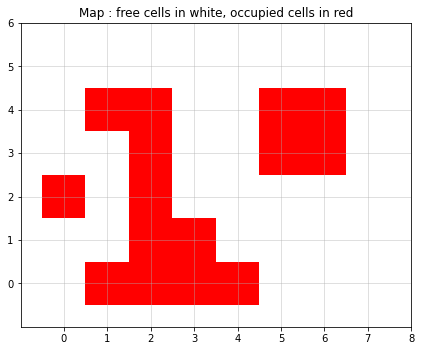

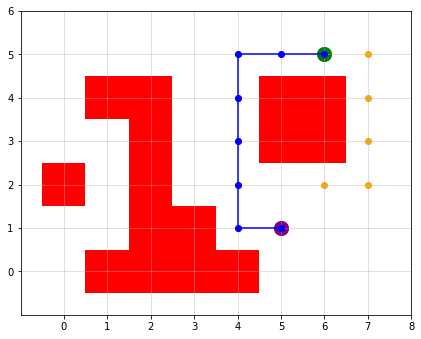

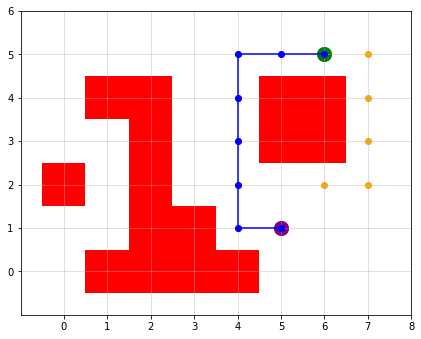

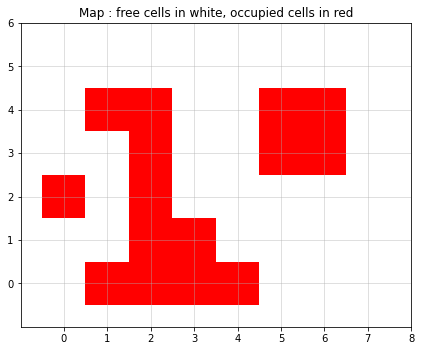

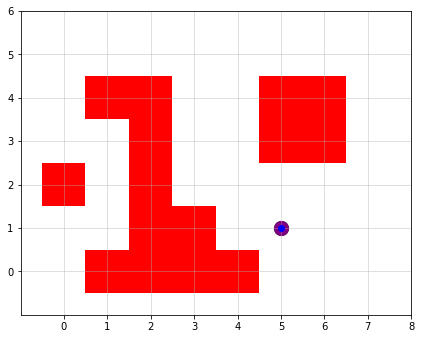

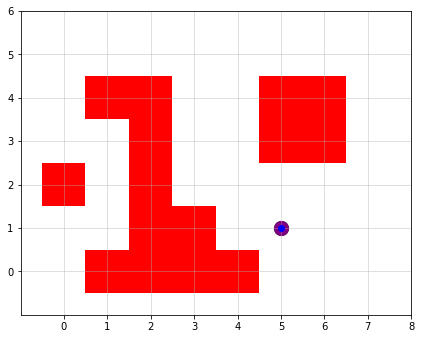

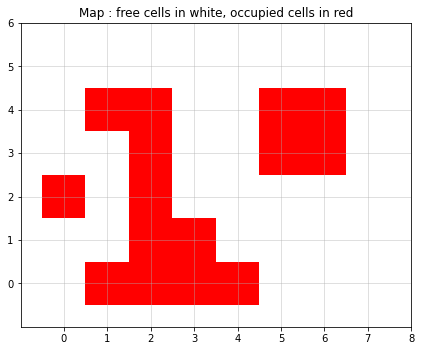

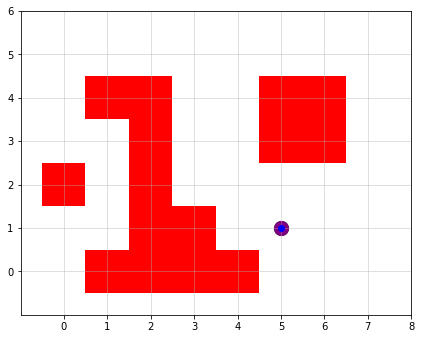

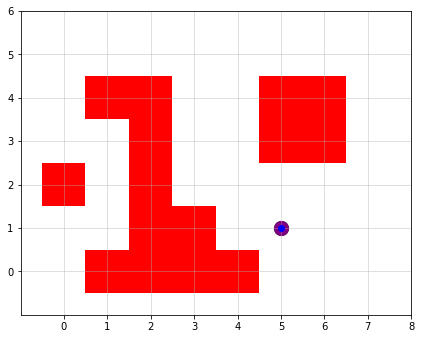

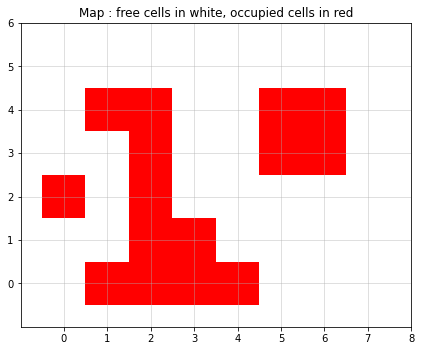

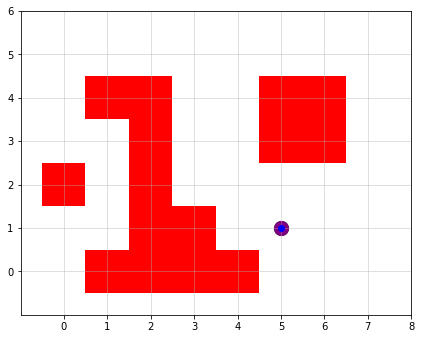

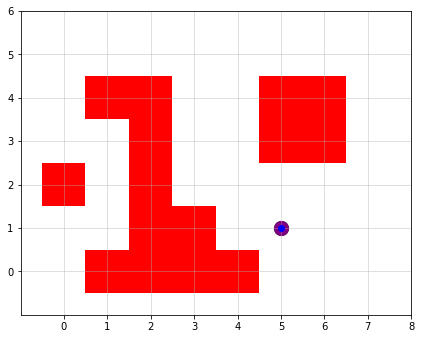

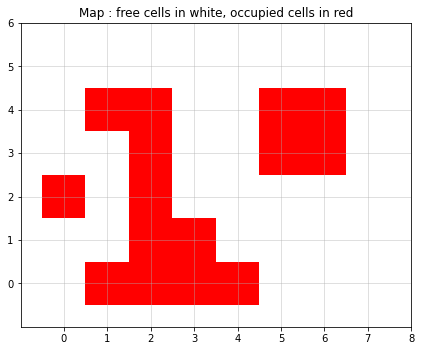

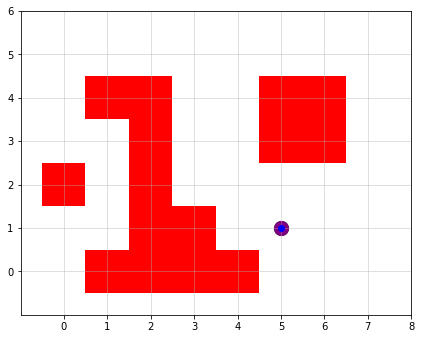

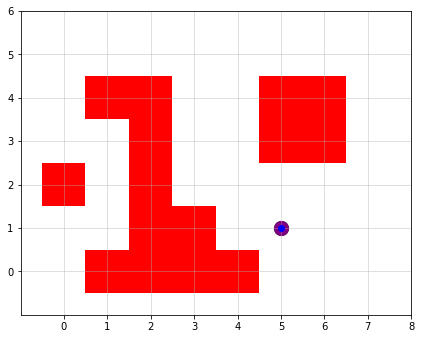

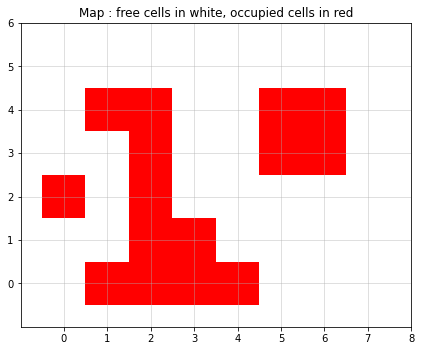

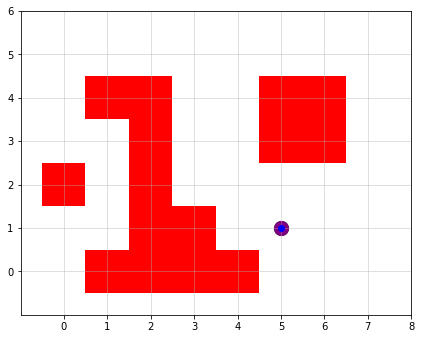

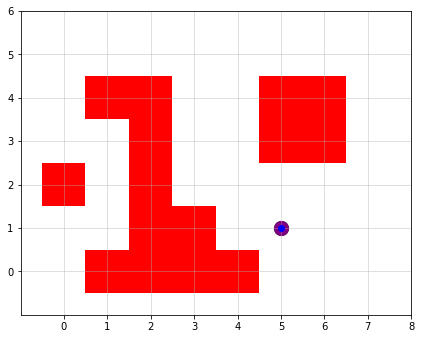

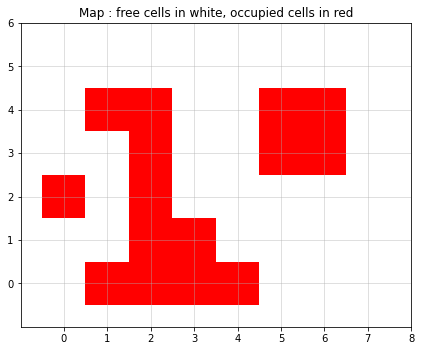

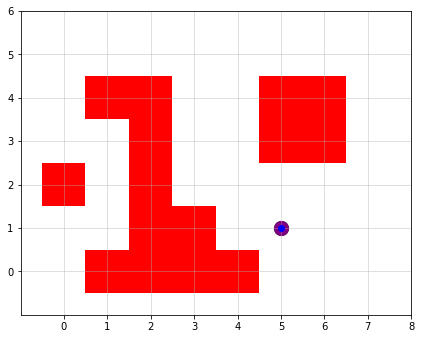

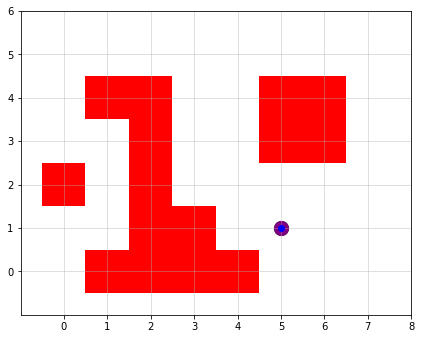

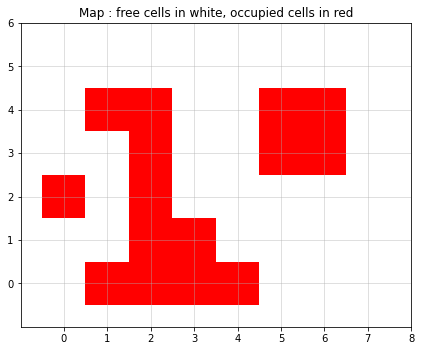

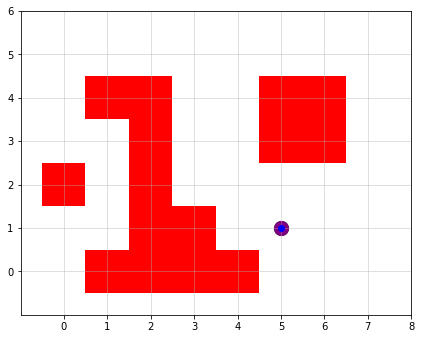

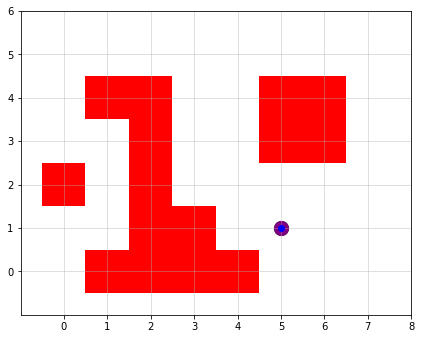

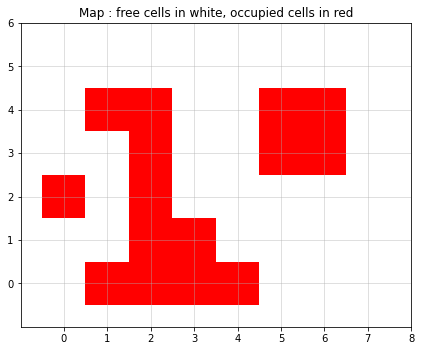

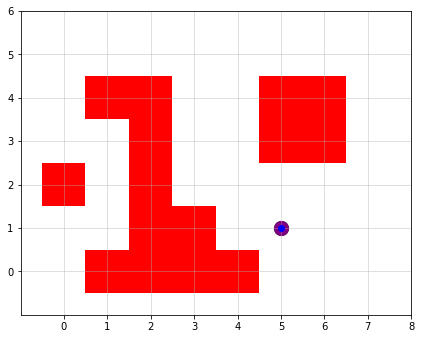

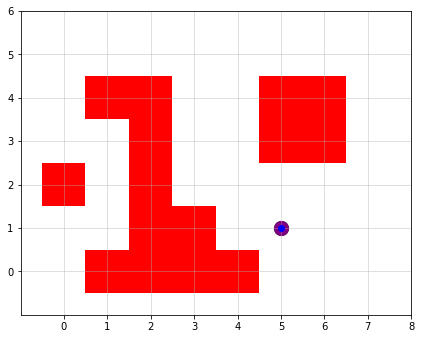

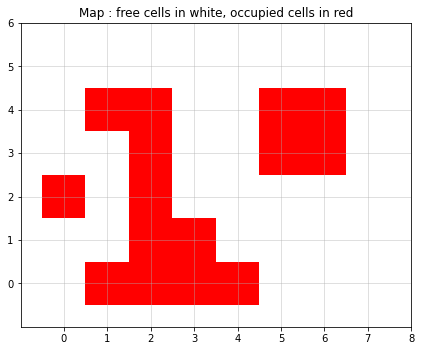

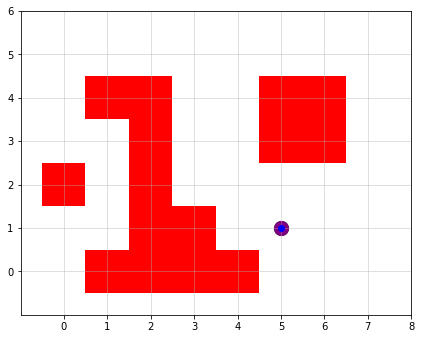

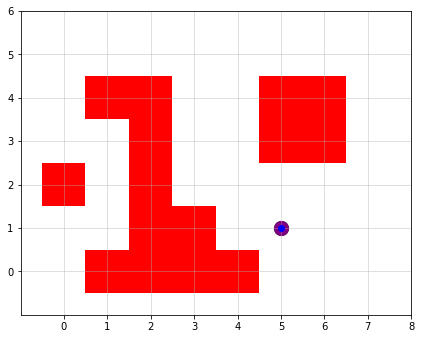

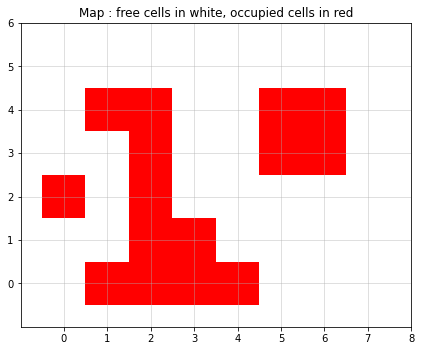

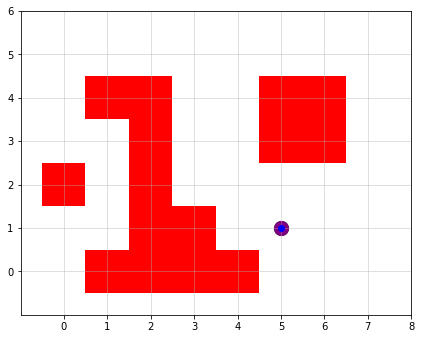

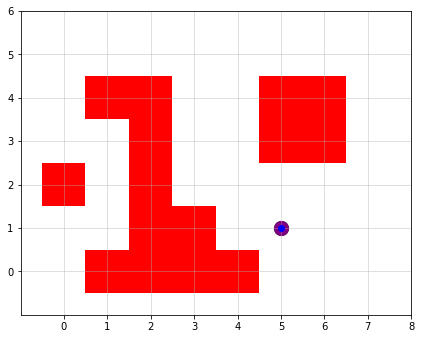

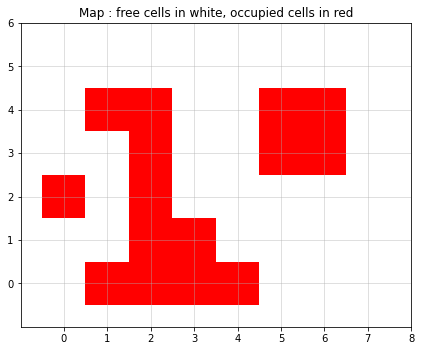

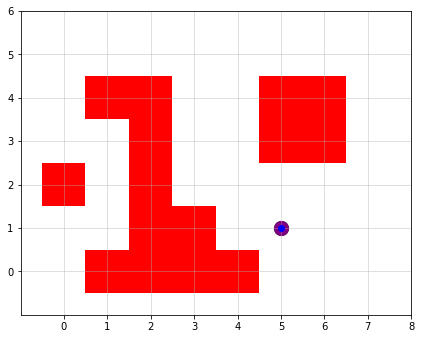

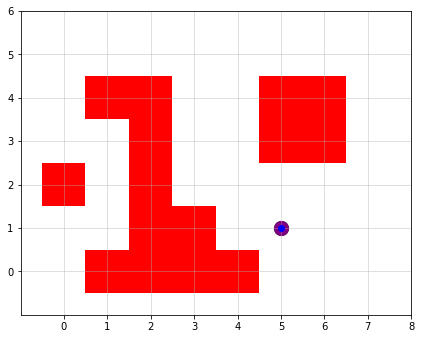

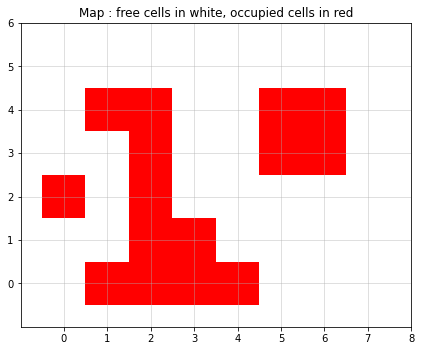

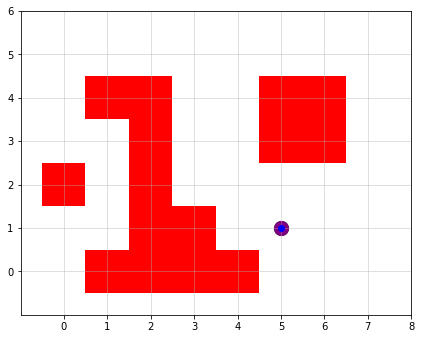

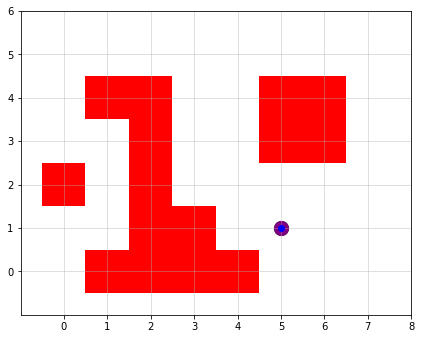

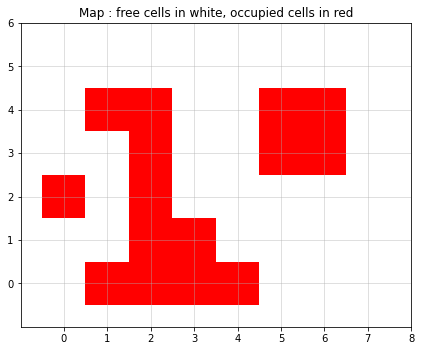

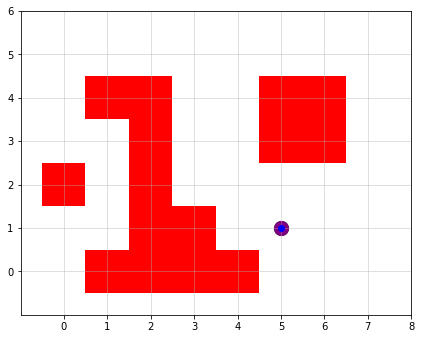

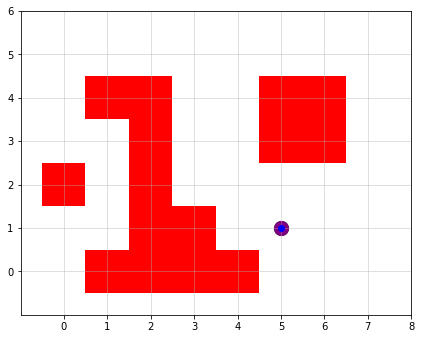

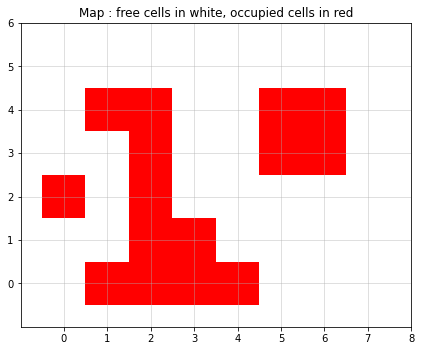

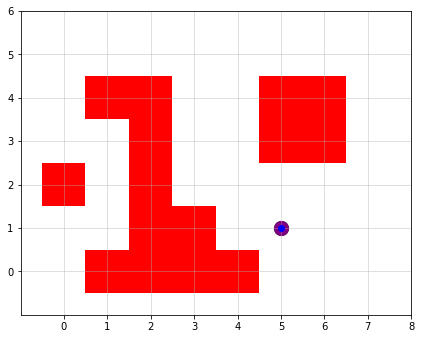

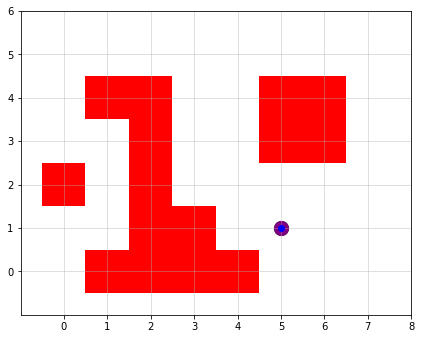

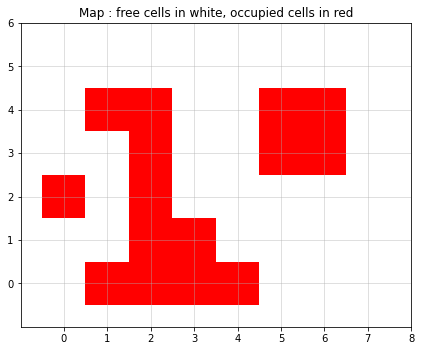

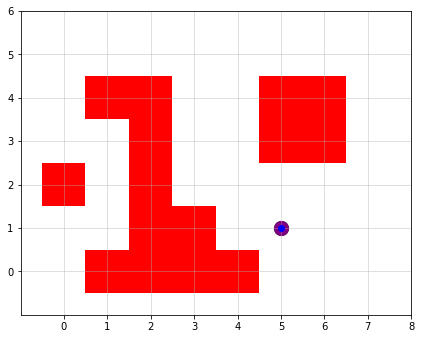

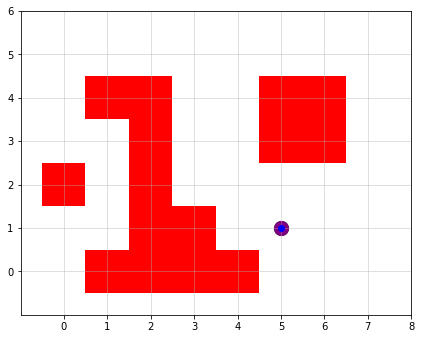

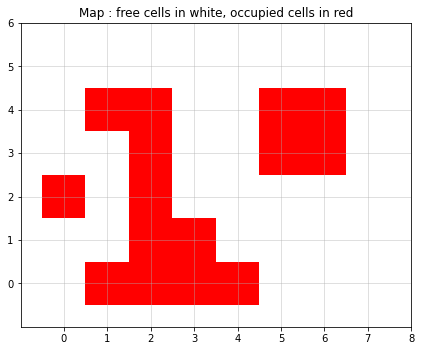

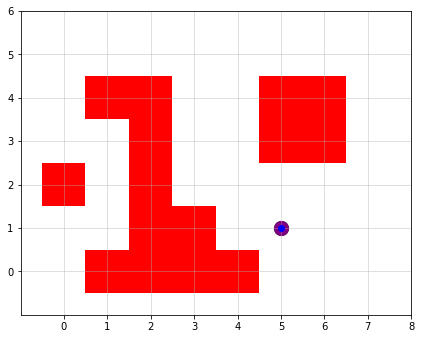

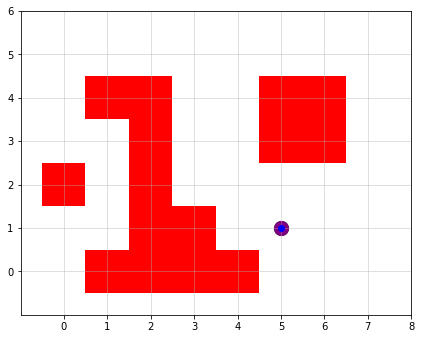

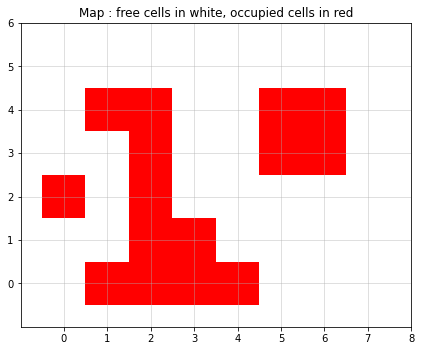

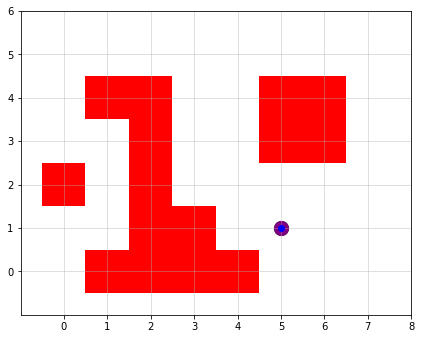

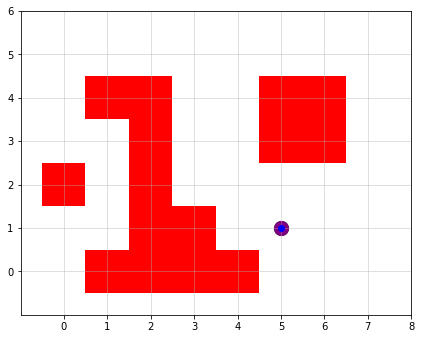

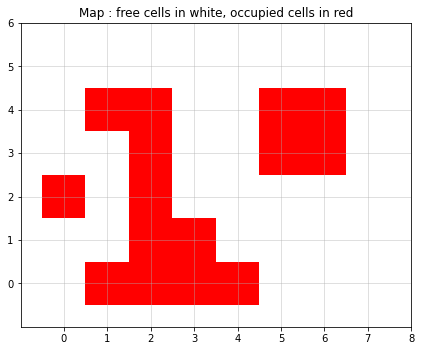

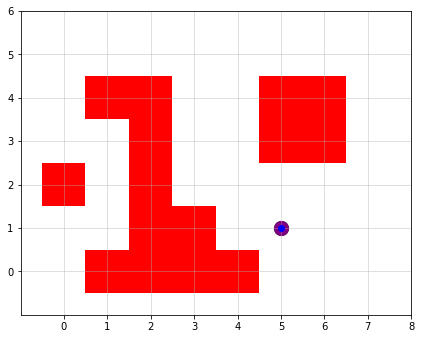

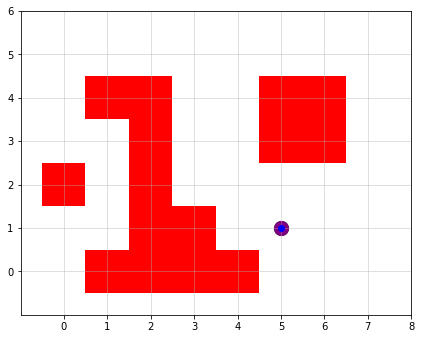

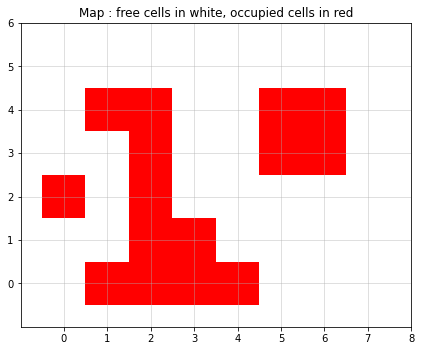

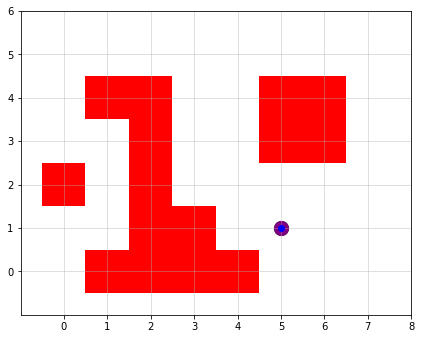

<Figure size 504x504 with 0 Axes>

In [18]:
A_star_move(client)

## 9. Conclusion

In conclusion, this project highlighted the challenges of collaborative programming, where differing perspectives and interpretations can lead to difficulties. When bugs arose in the main algorithm, identifying and resolving them proved challenging due to the lack of comprehension of the algorithm in its entierity.


Our experience with GitHub proved invaluable for project synchronization and streamlining algorithm transmission among team members. Moving forward, we recognize the importance of defining variables at the project's outset to avoid errors during the merge process. Additionally, establishing a standardized unit for distance, normalized during camera initialization, will enhance consistency.







### 10. References

ChatGPT to help with debugging

filter: https://automaticaddison.com/extended-kalman-filter-ekf-with-python-code-example/
